Trying the master equation and the effective one for $\Delta^{(1)} = \Delta^{(2)}$.

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import itertools 

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

from efficient_circuit_TEST_NEW import create_parametrized_ipd_circuit
from efficient_qiskit_solver_TEST_NEW import efficient_qiskit_solver
from qiskit_aer import AerSimulator
from find_optimal_layout import find_optimal_layout
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import Layout

In [12]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='ac55769048d74690dcec2e0219671ebcfb53eb44d32ee50608858b25572950cf0c789f133deb5ff884e342bffa02bed17167a747733f4e6ea69fd531bf4f39d7'
)
backend = service.backend('ibm_fez')

Below is the function that solves the original master equation without removing the cavity.

In [2]:
def solve(n_mol, n_cav, N, w_m, w_c, gamma, kappa, g, t, initial_state, initial_cavity_photons):

    evs = {}

    n = n_mol + n_cav # Total 

    h_0 = []

    h_int = []

    for i in range(n):

        identity_list = [x for x in itertools.chain.from_iterable(itertools.zip_longest([qeye(2)]*n_mol, [qeye(N)]*n_cav)) if x] # Tensor product of identities on each system
        
        if (i%2==0): # i even (i.e., molecule site)

            identity_list[i] = w_m[int(i/2)]*sigmap()*sigmam()

        else: # i odd (i.e., cavity site)
            
            identity_list[i] = w_c*destroy(N).dag()*destroy(N)

        h_0.append(tensor(identity_list))

        free_hamiltonian = sum(h_0)

    for i in range(n-1):

        identity_list = [x for x in itertools.chain.from_iterable(itertools.zip_longest([qeye(2)]*n_mol, [qeye(N)]*n_cav)) if x]

        if (i%2==0):

            identity_list[i] = sigmam()
            identity_list[i+1] = destroy(N).dag()

            first_summand = tensor(identity_list)

            identity_list[i] = sigmap()
            identity_list[i+1] = destroy(N)

            second_summand = tensor(identity_list)
        
        else:

            identity_list[i] = destroy(N)
            identity_list[i+1] = sigmap()

            first_summand = tensor(identity_list)

            identity_list[i] = destroy(N).dag()
            identity_list[i+1] = sigmam()

            second_summand = tensor(identity_list)

        h_int.append(g[i]*(first_summand + second_summand))

        interaction_hamiltonian = sum(h_int)

    hamiltonian = free_hamiltonian + interaction_hamiltonian

    initial_mole_state = Qobj(initial_state)
    initial_mole_state.dims = [[2,2],[1,1]]

    #initial_mole_state = [basis(2,1)]*n_mol

    #for index in initial_excited_molecule:

        #initial_mole_state[index] = basis(2,0)
    
    initial_cavity_state = tensor([basis(N, initial_cavity_photons)]*n_cav)

    #psi0 = tensor([x for x in itertools.chain.from_iterable(itertools.zip_longest(initial_mole_state, initial_cavity_state)) if x]) # Start with the molecule on the ground state and the cavity in a 1 photon fock state
    psi0 = tensor(initial_mole_state, initial_cavity_state)
    obs = []

    for i in range(n):

        identity_list = [x for x in itertools.chain.from_iterable(itertools.zip_longest([qeye(2)]*n_mol, [qeye(N)]*n_cav)) if x]

        if (i%2 == 0):

            identity_list[i] = sigmap()*sigmam()
            obs.append(tensor(identity_list))
        
        else:

            identity_list[i] = destroy(N).dag()*destroy(N)
            obs.append(tensor(identity_list))

    c_ops = []

    counter_mole = 0

    counter_cav = 0

    for i in range(n):

        identity_list = [x for x in itertools.chain.from_iterable(itertools.zip_longest([qeye(2)]*n_mol, [qeye(N)]*n_cav)) if x]

        if (i%2 == 0):

            identity_list[i] = np.sqrt(gamma[counter_mole])*sigmam()

            c_ops.append(tensor(identity_list))

            counter_mole = counter_mole + 1
        
        else:

            identity_list[i] = np.sqrt(kappa[counter_cav])*destroy(N)

            c_ops.append(tensor(identity_list))

            counter_cav = counter_cav + 1


    output = mesolve(H = hamiltonian, rho0 = psi0, tlist = t, e_ops = obs, c_ops = c_ops)

    for i in range(n):

        if (i%2 == 0):

            evs['spsm %d' %i] = output.expect[i]

        else:

            evs['adaga %d' %i] = output.expect[i]

    return evs

In [2]:
def solve_for_two(w_m, w_c, gamma, kappa, g, t, initial_state):

    ket_1 = Qobj([[0],[1]])
    ket_0 = Qobj([[1],[0]])

    lambda_plus = (1/np.sqrt(2))*(tensor(ket_0, ket_1) + tensor(ket_1, ket_0))
    lambda_plus.dims = [[2,2],[1,1]]

    e = tensor(ket_1, ket_1)
    e.dims = [[2,2],[1,1]]

    sigmam = ket_0*ket_1.dag()

    sigma_1 = tensor(sigmam, qeye(2), qeye(2))
    sigma_2 = tensor(qeye(2), sigmam, qeye(2))
    a = tensor(qeye(2), qeye(2), destroy(2))

    h_0 = w_m[0]*sigma_1.dag()*sigma_1 + w_m[1]*sigma_2.dag()*sigma_2 + w_c*a.dag()*a
    h_int = g[0]*(sigma_1.dag()*a + sigma_1*a.dag()) + g[1]*(sigma_2.dag()*a + sigma_2*a.dag())

    initial_molecular_state = Qobj(initial_state)
    initial_molecular_state.dims = [[2,2],[1,1]]

    rho0 = tensor(initial_molecular_state, basis(2,0))
    
    obs = [sigma_1.dag()*sigma_1, sigma_2.dag()*sigma_2, tensor(lambda_plus*lambda_plus.dag(), qeye(2)), tensor(e*e.dag(), qeye(2))]

    c_ops = [np.sqrt(gamma[0])*sigma_1, np.sqrt(gamma[1])*sigma_2, np.sqrt(kappa[0])*a]

    output = mesolve(H = h_0 + h_int, rho0 = rho0, tlist = t, e_ops = obs, c_ops = c_ops)

    evs_spsm_0 = output.expect[0]

    evs_spsm_1 = output.expect[1]

    evs_lambda_plus = output.expect[2]

    evs_e = output.expect[3]

    evs = [evs_spsm_0, evs_spsm_1, evs_lambda_plus, evs_e]

    return evs


In [11]:
ket_10 = tensor(ket_1, ket_0)
ket_10*ket_10.dag()

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [10]:
ket_1 = Qobj([[0],[1]])
ket_0 = Qobj([[1],[0]])

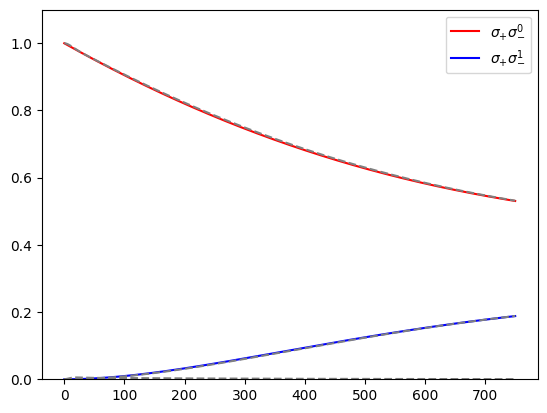

In [ ]:
t = np.linspace(0, 750, 1500)

n_mol = 2 # Number of molecules
n_cav = 1 # Number of cavities

w = [1.2, 1.2]
w_c = 1.1 # frequency of the cavity
N = 2 # Number of cavity Fock states
g = [0.01, 0.015] # Coupling strengths
i = 1j
det = [x-w_c for x in w] # Detunings

gamma = [0.8*(10**(-6)), 0.8*(10**(-6))]
kappa = [0.2]


self_factors = [((g[j]**2))/((0.5*kappa[0])**2 + det[j]**2) for j in range(n_mol)] # adim
cross_denom_1 = (kappa[0]/2)**2 + (kappa[0]/2)*(w[1] - w[0])*i + det[0]*det[1]
cross_denom_2 = (kappa[0]/2)**2 - (kappa[0]/2)*(w[1] - w[0])*i + det[0]*det[1]

eff_gamma = [ gamma[j] + self_factors[j]*kappa[0] for j in range(n_mol)]

H_0 = (w[0] + self_factors[0]*det[0])*(tensor(sigmap()*sigmam(), qeye(2))) + (w[1] + self_factors[1]*det[1])*tensor(qeye(2), sigmap()*sigmam())
H_int = (0.5*g[0]*g[1]*(det[0] + det[1]))*((1/cross_denom_1)*tensor(sigmam(),sigmap()) + (1/cross_denom_2)*tensor(sigmap(), sigmam()))

initial_excited_molecule = [0]

initial_cavity_photons = 0

indiv_decay_0 = np.sqrt(eff_gamma[0])*tensor(sigmam(), qeye(2))
indiv_decay_1 = np.sqrt(eff_gamma[1])*tensor(qeye(2), sigmam())

cross_c_op_1 = (g[0]*g[1]*(kappa[0] + i*(det[1] - det[0])))/cross_denom_1*lindblad_dissipator(a = tensor(sigmam(), qeye(2)), b = tensor(qeye(2), sigmam()))

cross_c_op_2 = (g[0]*g[1]*(kappa[0] + i*(det[0] - det[1])))/cross_denom_2*lindblad_dissipator(a = tensor(qeye(2), sigmam()), b = tensor(sigmam(), qeye(2)))

rho0 = basis(dimensions = [2]*2, n = [0,1])

c_ops = [indiv_decay_0, indiv_decay_1, cross_c_op_1, cross_c_op_2]

obs = [tensor(sigmap()*sigmam(), qeye(2)), tensor(qeye(2), sigmap()*sigmam())]

output = mesolve(H = H_0 + H_int , rho0 = rho0, tlist = t, e_ops = obs, c_ops = c_ops)

evs_spsm_0 = output.expect[0]

evs_spsm_1 = output.expect[1]


plt.plot(t, evs_spsm_0, color = 'red', label = '$\\sigma_{+}\\sigma_{-}^{0}$')
plt.plot(t, evs_spsm_1, color = 'blue', label = '$\\sigma_{+}\\sigma_{-}^{1}$')

evs = solve(n_mol, n_cav, N, w, w_c, gamma, kappa, g, t, initial_excited_molecule, initial_cavity_photons)

for key in evs:

    plt.plot(t, evs[key], color = 'grey', linestyle = 'dashed')

plt.legend()
plt.ylim([0, 1.1])
plt.show()

Now for the quantum circuit, we will use a modified version of the `efficient_circuit.py` and `efficient_qiskit_solver.py`. 

In [4]:
def markov_solve(n_mol, w, w_c, gamma, kappa, g, t, initial_state):

    i = 1j
    det = [x-w_c for x in w]

    self_factors = [((g[j]**2))/((0.5*kappa[0])**2 + det[j]**2) for j in range(n_mol)] # adim
    cross_denom_1 = (kappa[0]/2)**2 + (kappa[0]/2)*(w[1] - w[0])*i + det[0]*det[1]
    cross_denom_2 = (kappa[0]/2)**2 - (kappa[0]/2)*(w[1] - w[0])*i + det[0]*det[1]

    eff_gamma = [ gamma[j] + self_factors[j]*kappa[0] for j in range(n_mol)]

    H_0 = (w[0] + self_factors[0]*det[0])*(tensor(sigmap()*sigmam(), qeye(2))) + (w[1] + self_factors[1]*det[1])*tensor(qeye(2), sigmap()*sigmam())
    H_int = (0.5*g[0]*g[1]*(det[0] + det[1]))*((1/cross_denom_1)*tensor(sigmam(),sigmap()) + (1/cross_denom_2)*tensor(sigmap(), sigmam()))

    indiv_decay_0 = np.sqrt(eff_gamma[0])*tensor(sigmam(), qeye(2))
    indiv_decay_1 = np.sqrt(eff_gamma[1])*tensor(qeye(2), sigmam())

    cross_c_op_1 = (g[0]*g[1]*(kappa[0] + i*(det[1] - det[0])))/cross_denom_1*lindblad_dissipator(a = tensor(sigmam(), qeye(2)), b = tensor(qeye(2), sigmam()))

    cross_c_op_2 = (g[0]*g[1]*(kappa[0] + i*(det[0] - det[1])))/cross_denom_2*lindblad_dissipator(a = tensor(qeye(2), sigmam()), b = tensor(sigmam(), qeye(2)))

    #initial_mole_state = [basis(2,1)]*n_mol

    #for index in initial_excited_molecule:

        #initial_mole_state[index] = basis(2,0)

    #rho0 = tensor(initial_mole_state)

    rho0 = Qobj(initial_state[::-1])
    rho0.dims = [[2,2],[1,1]]
    #rho0.dims = [[2,2],[2,2]]

    c_ops = [indiv_decay_0, indiv_decay_1]#, cross_c_op_1, cross_c_op_2]

    obs = [tensor(sigmap()*sigmam(), qeye(2)), tensor(qeye(2), sigmap()*sigmam())]

    output = mesolve(H = H_0 + H_int , rho0 = rho0, tlist = t, e_ops = obs, c_ops = c_ops)

    evs_spsm_0 = output.expect[0]

    evs_spsm_1 = output.expect[1]

    evs = [evs_spsm_0, evs_spsm_1]

    return evs

In [5]:
def markov_solve_diagonal_basis_manual(n_mol, w, w_c, gamma, kappa, g, t, initial_state):

    e = Qobj([[0],[0],[0],[1]])
    lambda_plus = Qobj([[0],[0],[1],[0]])
    lambda_minus = Qobj([[0],[1],[0],[0]])
    gr = Qobj([[1],[0],[0],[0]])

    sigma_gplus = Qobj(lambda_plus*gr.dag()).dag()
    sigma_gminus = Qobj(lambda_minus*gr.dag()).dag()
    sigma_pluse = Qobj(e*lambda_plus.dag()).dag()
    sigma_minuse = Qobj(e*lambda_minus.dag()).dag()

    i = 1j
    det = [x-w_c for x in w]

    self_factors = [((g[j]**2))/((0.5*kappa[0])**2 + det[j]**2) for j in range(n_mol)] # adim
    cross_denom_1 = (kappa[0]/2)**2 + (kappa[0]/2)*(w[1] - w[0])*i + det[0]*det[1]

    eff_gamma = [ gamma[j] + self_factors[j]*kappa[0] for j in range(n_mol)]
    gamma_cross = (g[0]*g[1]*(kappa[0] + i*(det[1] - det[0])))/cross_denom_1
    omega_eff = w[0] + self_factors[0]*det[0]
    g_eff = (0.5*g[0]*g[1]*(det[0] + det[1]))*(1/cross_denom_1)

    H = Qobj(np.array([[0, 0, 0, 0], [0, omega_eff - g_eff, 0, 0], [0, 0, omega_eff+g_eff, 0],[0, 0, 0, 2*omega_eff]]))

    # This below is the initial state on the computational basis

    comp_rho0 = Qobj(initial_state)

    #initial_mole_state = [basis(2,0)]*n_mol

    #for index in initial_excited_molecule:

        #initial_mole_state[index] = basis(2,1)

    # We will define the basis change matrix and apply it to transform rho0 into the diagonal basis.

    U = Qobj(np.array([[1, 0, 0, 0], [0, -1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 0, 0, 1]]))

    #comp_rho0 = tensor(initial_mole_state)
    #comp_rho0.dims = [[4],[1]]

    rho0 = U*comp_rho0

    diss_gplus = np.sqrt(gamma_cross + (eff_gamma[0] + eff_gamma[1])/2)*sigma_gplus
    diss_gminus = np.sqrt(- gamma_cross + (eff_gamma[0] + eff_gamma[1])/2)*sigma_gminus
    diss_pluse = np.sqrt(gamma_cross + (eff_gamma[0] + eff_gamma[1])/2)*sigma_pluse
    diss_minuse = np.sqrt(- gamma_cross + (eff_gamma[0] + eff_gamma[1])/2)*sigma_minuse

    cross_gplus_pluse = (gamma_cross + (eff_gamma[0] + eff_gamma[1])/2)*lindblad_dissipator(a = sigma_gplus, b = sigma_pluse)
    cross_gminus_minuse = (gamma_cross - (eff_gamma[0] + eff_gamma[1])/2)*lindblad_dissipator(a = sigma_gminus, b = sigma_minuse)
    cross_pluse_gplus = (gamma_cross + (eff_gamma[0] + eff_gamma[1])/2)*lindblad_dissipator(a = sigma_pluse, b = sigma_gplus)
    cross_minuse_gminus = (gamma_cross - (eff_gamma[0] + eff_gamma[1])/2)*lindblad_dissipator(a = sigma_minuse, b = sigma_gminus)

    #c_ops = [diss_gplus, diss_gminus, diss_pluse, diss_minuse]#, cross_gplus_pluse, cross_gminus_minuse, cross_pluse_gplus, cross_minuse_gminus]
    c_ops = [diss_pluse, diss_minuse]


    sigmaplus_sigmaminus_1 = (1/2)*(lambda_plus*gr.dag() + lambda_minus*gr.dag() + e*lambda_plus.dag() - e*lambda_minus.dag())*(lambda_plus*gr.dag() + lambda_minus*gr.dag() + e*lambda_plus.dag() - e*lambda_minus.dag()).dag()
    sigmaplus_sigmaminus_2 = (1/2)*(lambda_plus*gr.dag() - lambda_minus*gr.dag() + e*lambda_plus.dag() + e*lambda_minus.dag())*(lambda_plus*gr.dag() - lambda_minus*gr.dag() + e*lambda_plus.dag() + e*lambda_minus.dag()).dag()
    obs = [sigmaplus_sigmaminus_1, sigmaplus_sigmaminus_2]

    output = mesolve(H = H , rho0 = rho0, tlist = t, e_ops = obs, c_ops = c_ops)

    evs_spsm_0 = output.expect[0]

    evs_spsm_1 = output.expect[1]

    evs = [evs_spsm_0, evs_spsm_1]

    return evs

First we will check that the circuit works without the cross dissipators

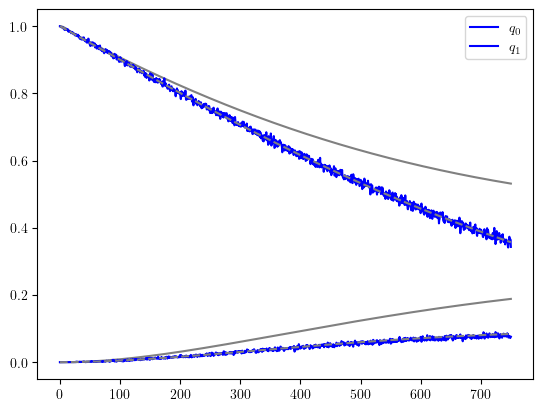

In [6]:
n_mol = 2
t = np.linspace(0, 750, 1500)

n_mol = 2 # Number of molecules
n_cav = 1 # Number of cavities

w = [1.2, 1.2]
w_c = 1.1 # frequency of the cavity
N = 2 # Number of cavity Fock states
g = [0.01, 0.015]

gamma = [0.8*(10**(-6)), 0.8*(10**(-6))]
kappa = [0.2]
lam = [0,0]

r = 8

initial_excited_molecule = [0]
initial_cavity_photons = 0

backend = AerSimulator()
optimization_level = 0
options = {'resilience_level' : 1,
           'default_shots' : 1024,
           'optimization_level' : 1}

population = efficient_qiskit_solver(n = n_mol, omega_m = w, omega_c = w_c, gamma = gamma, lam = lam, g = g, kappa = kappa, t = t, r = r, initial_excited = initial_excited_molecule, backend = backend, optimization_level = optimization_level, options = options)
markov_population = markov_solve(n_mol, w, w_c, gamma, kappa, g, t)
exact_population = solve(n_mol, n_cav, N, w, w_c, gamma, kappa, g, t, initial_excited_molecule, initial_cavity_photons)

plt.plot(t, exact_population['spsm 0'], color = 'grey')
plt.plot(t, exact_population['spsm 2'], color = 'grey')

for i in range(n_mol):

    plt.plot(t, population[i], color = 'blue', label = '$q_{%d}$' %int(i))

plt.plot(t, markov_population[0], linestyle = 'dashed', color = 'grey')
plt.plot(t, markov_population[1], linestyle = 'dashed', color = 'grey')
plt.legend()

plt.show()

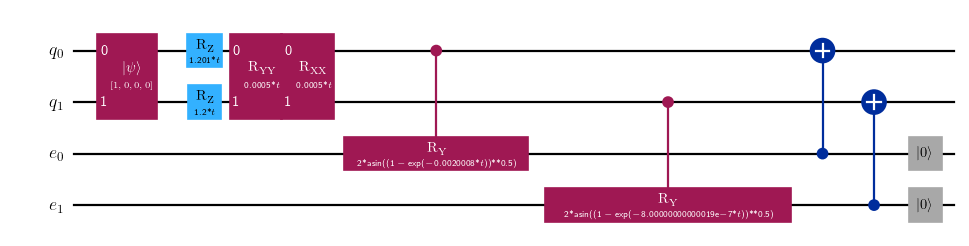

In [3]:
n_mol = 2
t = np.linspace(0, 750, 1500)

n_mol = 2 # Number of molecules
n_cav = 1 # Number of cavities

w = [1.2, 1.2]
w_c = 1.1 # frequency of the cavity
N = 2 # Number of cavity Fock states
g = [0.01, 0.01]

gamma = [0.8*(10**(-6)), 0.8*(10**(-6))]
kappa = [0.2]
lam = [0,0]

r = 1

initial_state = [1,0,0,0]
initial_cavity_photons = 0

qc = create_parametrized_ipd_circuit(n_mol = n_mol, omega_m = w, omega_c = w_c,
                                    gamma = gamma, lam = lam, g = g, kappa = kappa,
                                    r = r, initial_qubit_state = initial_state)


#layout = find_optimal_layout(10**3, qc, backend, 3)
#pm = generate_preset_pass_manager(backend  = backend, optimization_level = 3)
#transpiled_qc = pm.run(qc)
#print(transpiled_qc.depth(lambda instr: len(instr.qubits) > 1))
qc.draw('mpl', scale = 0.8)
#transpiled_qc.draw('mpl', scale = 0.6, idle_wires=False)

#observables = [obs, population_e]
#transpiled_observables = [x.apply_layout(transpiled_qc.layout) for x in observables]
#transpiled_observables
#reshaped_obs = np.fromiter(transpiled_observables, dtype=object)

#reshaped_obs = reshaped_obs.reshape((2, 1))
#reshaped_obs

In [9]:
initial_state = [2]
initial_state[0] = initial_state[0] + 2
initial_state

[4]

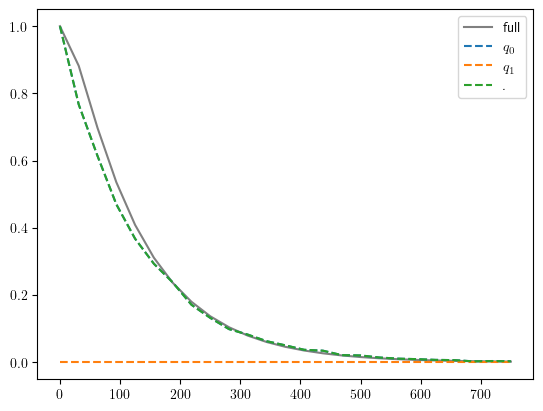

In [7]:
n_mol = 2
t = np.linspace(0, 750, 25)

n_mol = 2 # Number of molecules
n_cav = 1 # Number of cavities

w = [1.1, 1.1]
w_c = 1.1 # frequency of the cavity
N = 2 # Number of cavity Fock states
g = [0.01, 0.01]

gamma = [0.8*(10**(-6)), 0.8*(10**(-6))]
kappa = [0.1]
lam = [0,0]

r = 1

initial_state = [0,1/np.sqrt(2),1/np.sqrt(2),0] # Coordinates in |q_0q_1> = |00>, |01>, |10>, |11>
initial_qubit_state = [0,1,0,0]

initial_cavity_photons = 0

backend = AerSimulator()
optimization_level = 0
options = {'resilience_level' : 1,
           'default_shots' : 1024,
           'optimization_level' : 1}

population = efficient_qiskit_solver(n = n_mol, omega_m = w, omega_c = w_c, gamma = gamma, lam = lam, g = g, kappa = kappa, t = t, r = r, initial_state = initial_qubit_state, backend = backend, optimization_level = optimization_level, options = options)
#markov_population = markov_solve(n_mol, w, w_c, gamma, kappa, g, t, initial_state)
#diagonal_pop = markov_solve_diagonal_basis_manual(n_mol, w, w_c, gamma, kappa, g, t, initial_state)
exact_population = solve_for_two(w, w_c, gamma, kappa, g, t, initial_state)

plt.plot(t, exact_population[2], color = 'grey', label = 'full')
#plt.plot(t, exact_population[1], color = 'grey')

for i in range(n_mol):

    plt.plot(t, population[i], linestyle = 'dashed', label = '$q_{%d}$' %int(i))

plt.plot(t, population[3], linestyle = 'dashed', label = '.')

#plt.plot(t, markov_population[0], linestyle = 'dashed', color = 'grey', label = 'computational basis (only $\\mathcal{D}_{\\sigma_1}, \\mathcal{D}_{\\sigma_2}$)')
#plt.plot(t, markov_population[1], linestyle = 'dashed', color = 'grey')
#plt.plot(t, diagonal_pop[0], linestyle = 'dashed', color = 'purple', label = 'coupled basis (only $\\mathcal{D}_{+E}, \\mathcal{D}_{-E}$)')
#plt.plot(t, diagonal_pop[1], linestyle = 'dashed', color = 'purple')

###########################################################################################################################################################################################

detunings = [x-w_c for x in w]
denom = ((0.5*kappa[0])**2 + detunings[0]**2)
gamma_eff = [gamma[i] + (((g[i]**2))/denom)*kappa[0] for i in range(n_mol)]
gamma_cross = (g[0]*g[1]*(kappa[0]))/denom 
gamma_plus = (gamma_cross + (gamma_eff[0] + gamma_eff[1])/2)
gamma_minus = (-gamma_cross + (gamma_eff[0] + gamma_eff[1])/2)
eff = (gamma_plus + gamma_minus)

#plt.plot(t, np.exp(-eff/2*t), label = '$e^{-(\\gamma_+ + \\gamma_-)t/2}$')
#plt.plot(t, 1/2*(np.exp(-gamma_plus*t) + np.exp(-gamma_minus*t)), label = '$1/2(e^{-\\gamma_+t} + e^{-\\gamma_-t})$')

plt.legend()

plt.show()

In [11]:
from qiskit.quantum_info import SparsePauliOp

identity_str = list('I'*2*2)

identity_str[0] = 'Z'

identity_str.reverse()

spin_op = ''.join(identity_str)

obs = 0.5*(SparsePauliOp('I'*(2*2)) - SparsePauliOp(spin_op))

obs.size

2

In [9]:
population_e = SparsePauliOp('II').tensor(SparsePauliOp.from_operator(np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])))
population_e

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ'],
              coeffs=[ 0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j])

In [69]:
initial_mole_state = [basis(2,1)]*n_mol

for index in initial_excited_molecule:

    initial_mole_state[index] = basis(2,0)

rho0 = tensor(initial_mole_state)
rho0.dims = [[4],[1]]
rho0*rho0.dag()

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [81]:
U = Qobj(np.array([[1, 0, 0, 0], [0, -1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 0, 0, 1]]))
U

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.          0.          0.          0.        ]
 [ 0.         -0.70710678  0.70710678  0.        ]
 [ 0.          0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.          1.        ]]

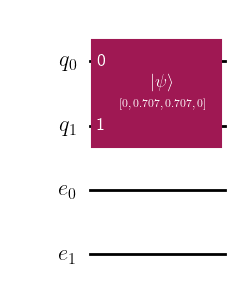

In [15]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import Statevector

initial = [0, 1, 1, 0]
init_state = Statevector(initial)
system = QuantumRegister(2, 'q')
environment = QuantumRegister(2, 'e')
qc = QuantumCircuit(system, environment)
qc.initialize(init_state, qubits = system, normalize = True)
qc.draw('mpl')

In [63]:
e = Qobj([[0],[0],[0],[1]])
lambda_plus = Qobj([[0],[0],[1],[0]])
lambda_minus = Qobj([[0],[1],[0],[0]])
gr = Qobj([[1],[0],[0],[0]])

sigma_gplus = Qobj(lambda_plus*gr.dag()).dag()
sigma_gplus

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [18]:
ket1 = basis(4,2)
ket1

Quantum object: dims=[[4], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

In [19]:
Qobj([0,0,1,0])

Quantum object: dims=[[4], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

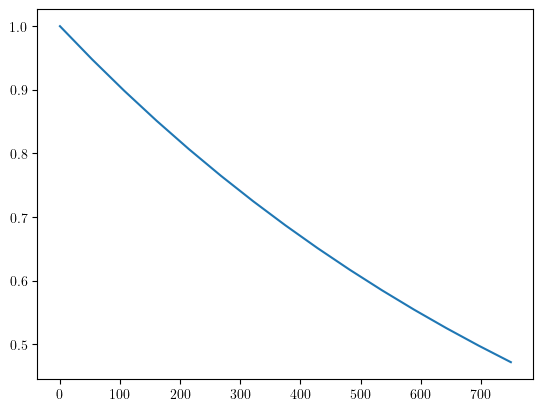

In [41]:
omega_m = [1.2, 1.2]

omega_c = 1.1

detunings = [x-omega_c for x in omega_m]

t = np.linspace(0, 750, 15)

denom = ((0.5*kappa[0])**2 + detunings[0]**2)

gamma_eff = [gamma[i] + (((g[i]**2))/denom)*kappa[0] for i in range(n_mol)]

gamma_cross = (g[0]*g[1]*(kappa[0]))/denom 

p_plus = (np.exp(-t*((gamma_eff[0] + gamma_eff[1])/2)))

p_minus = np.exp(-t*(-gamma_cross + (gamma_eff[0] + gamma_eff[1])/2))

plt.plot(t, p_plus)
plt.show()

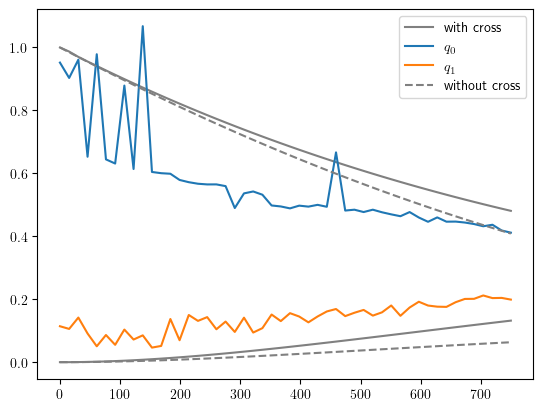

In [9]:
n_mol = 2
t = np.linspace(0, 750, 50)

n_mol = 2 # Number of molecules
n_cav = 1 # Number of cavities

w = [1.2, 1.2]
w_c = 1.1 # frequency of the cavity
N = 2 # Number of cavity Fock states
g = [0.01, 0.01]

gamma = [0.8*(10**(-6)), 0.8*(10**(-6))]
kappa = [0.2]
lam = [0,0]

r = 1

initial_excited_molecule = [0]
initial_cavity_photons = 0

backend = service.backend('ibm_fez')
optimization_level = 3
options = {'resilience_level' : 2,
           'default_shots' : 10**4,
           'optimization_level' : 1}

population = efficient_qiskit_solver(n = n_mol, omega_m = w, omega_c = w_c, gamma = gamma, lam = lam, g = g, kappa = kappa, t = t, r = r, initial_excited = initial_excited_molecule, backend = backend, optimization_level = optimization_level, options = options)
markov_population = markov_solve(n_mol, w, w_c, gamma, kappa, g, t)
exact_population = solve(n_mol, n_cav, N, w, w_c, gamma, kappa, g, t, initial_excited_molecule, initial_cavity_photons)

plt.plot(t, exact_population['spsm 0'], color = 'grey', label = 'with cross')
plt.plot(t, exact_population['spsm 2'], color = 'grey')

for i in range(n_mol):

    plt.plot(t, population[i], label = '$q_{%d}$' %int(i))

plt.plot(t, markov_population[0], linestyle = 'dashed', color = 'grey', label = 'without cross')
plt.plot(t, markov_population[1], linestyle = 'dashed', color = 'grey')
plt.legend()

plt.show()

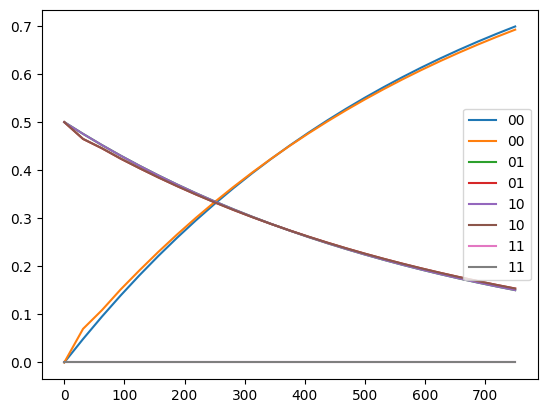

In [2]:
from updated_qutip_solver import solve_markovian
from original_qutip_solver import solve_original
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 750, 25)

w = [1.2, 1.2]
w_c = 1.1 # frequency of the cavity
g = [0.01, 0.01]

gamma = [0.8*(10**(-6)), 0.8*(10**(-6))]
kappa = [0.1]
lam = [0,0]

r = 1

initial_state = [0,1/np.sqrt(2),1/np.sqrt(2),0] # Coordinates in |q_0q_1> = |00>, |01>, |10>, |11>

evs = solve_markovian(w, w_c, gamma, kappa, g, t, initial_state)
original_evs = solve_original(w, w_c, gamma, kappa, g, t, initial_state)

labels = ['00', '01', '10', '11', 'G', '-', '+', 'E']

for i in range(4):

    plt.plot(t, evs[labels[i]], label = labels[i])
    plt.plot(t, original_evs[labels[i]], label = labels[i])

#for key, item in original_evs.items():

    #plt.plot(t, item, linestyle = 'dashed', label = key)
plt.legend()
plt.show()

In [7]:
from qutip import *

about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.2
Numpy Version:      1.26.4
Scipy Version:      1.13.1
Cython Version:     None
Matplotlib Version: 3.9.0
Python Version:     3.12.3
Number of CPUs:     36
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Windows (AMD64)
Installation path:  c:\Users\Benjamin\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated 

In [11]:
a = [2,3,4]
a = [x +1 for x in a]
a

[3, 4, 5]

[3,
 4,
 5,
 <generator object <genexpr> at 0x000002D5D3C2D180>,
 <generator object <genexpr> at 0x000002D5D3C2CA00>,
 <generator object <genexpr> at 0x000002D5D3C2D600>,
 <generator object <genexpr> at 0x000002D5D3C2D480>,
 <generator object <genexpr> at 0x000002D5D3C2D840>]

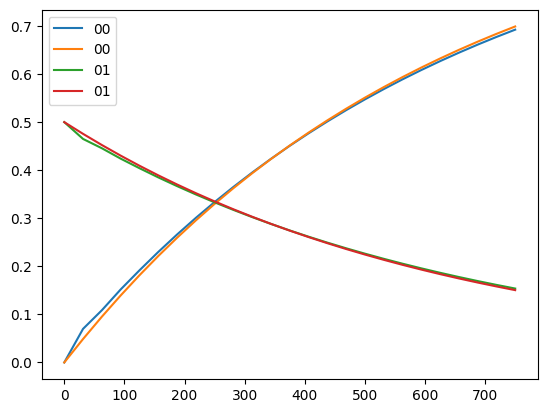

In [6]:
from merge_methods import solve_master_equation
import numpy as np 
import matplotlib.pyplot as plt

t = np.linspace(0, 750, 25)

w = [1.2, 1.2]
w_c = 1.1 # frequency of the cavity
g = [0.01, 0.01]

gamma = [0.8*(10**(-6)), 0.8*(10**(-6))]
kappa = [0.1]
lam = [0,0]

r = 1

initial_state = [0,1/np.sqrt(2),1/np.sqrt(2),0] # Coordinates in |q_0q_1> = |00>, |01>, |10>, |11>


evs_original = solve_master_equation(w, w_c, gamma, kappa, g, t, initial_state, 'original')
evs_markov = solve_master_equation(w, w_c, gamma, kappa, g, t, initial_state, 'markovian')

labels = ['00', '01', '10', '11', 'G', '-', '+', 'E']

for i in range(2):

    plt.plot(t, evs_original[labels[i]], label = labels[i])
    plt.plot(t, evs_markov[labels[i]], label = labels[i])

#plt.plot(t, evs_markov['+'])

#for key, item in original_evs.items():

    #plt.plot(t, item, linestyle = 'dashed', label = key)
plt.legend()
plt.show()

In [7]:
state = np.matrix([0,1/np.sqrt(2),1/np.sqrt(2),0])
a = np.array([[1, 0, 0, 0], [0, -1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 0, 0, 1]])

a*state.transpose()

matrix([[0.],
        [0.],
        [1.],
        [0.]])

In [11]:
import numpy as np

state = [0,1,1,0]
P = np.array([[1, 0, 0, 0], [0, -1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 0, 0, 1]])

initial_qubit_state = np.matmul(P,state)
initial_qubit_state

array([0.        , 0.        , 1.41421356, 0.        ])

In [4]:
from merge_methods import solve_master_equation

evs = solve_master_equation(omega, omega_c, )

In [12]:
ket_0 = np.array([[1],[0]])
np.kron(ket_0, ket_0.transpose())

array([[1, 0],
       [0, 0]])

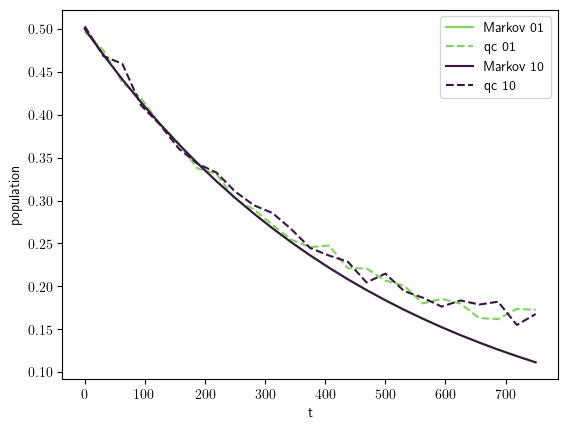

In [3]:
from merge_methods_TEST import solve_master_equation
from efficient_qiskit_solver_markovian import markovian_qiskit_solver
import numpy as np 
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

t = np.linspace(0, 750, 25)

w = [1.2, 1.2]
w_c = 1.1 # frequency of the cavity
g = [0.01, 0.01]

gamma = [0.8*(10**(-6)), 0.8*(10**(-6))]
kappa = [0.2]

r = 1

initial_state = [0, 1/np.sqrt(2), 1/np.sqrt(2), 0] # Coordinates in |q_0q_1> = |00>, |01>, |10>, |11>

#initial_state = [0,0,0,1]

backend = AerSimulator()
optimization_level = 0
options = {'resilience_level' : 1,
           'default_shots' : 1024,
           'optimization_level' : 1}

#evs_original = solve_master_equation(w, w_c, gamma, kappa, g, t, initial_state, 'original')
#evs_markov = solve_master_equation(w, w_c, gamma, kappa, g, t, initial_state, 'markovian')
evs_diagonal = solve_master_equation(w, w_c, gamma, kappa, g, t, initial_state, 'diagonal')

evs_qc = markovian_qiskit_solver(2, w, w_c, gamma, g, kappa, t, r, initial_state, backend, optimization_level, options)

#labels =  ['E', '-', 'G']

labels = ['01', '10']

import random

def random_color():
    return (random.random(), random.random(), random.random())

for l in labels:

    color = random_color()
    #plt.plot(t, evs_original[l], label = l)
    #plt.plot(t, evs_markov[l], label = l)
    plt.plot(t, evs_diagonal[l], label = 'Markov %s' %l, color = color)
    plt.plot(t, evs_qc[l], linestyle = 'dashed', label = 'qc %s' %l, color = color)

    
plt.ylabel('population')
plt.xlabel('t')
plt.legend()
plt.show()

In [5]:
from qutip import Qobj
gr = Qobj([[1],[0],[0],[0]])
lambda_minus = Qobj([[0],[1],[0],[0]])
lambda_plus = Qobj([[0],[0],[1],[0]])
e = Qobj([[0],[0],[0],[1]])
# Operators definition

sigma_gplus = Qobj(gr*lambda_plus.dag())
sigma_gminus = Qobj(gr*lambda_minus.dag())
sigma_pluse = Qobj(lambda_plus*e.dag())
sigma_minuse = Qobj(lambda_minus*e.dag())

In [9]:
gr

Quantum object: dims=[[4], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [18]:
i = 1j
from qutip import sigmax, sigmay

sigmax() + i*sigmay()


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=False
Qobj data =
[[0. 2.]
 [0. 0.]]

In [12]:
from qutip import tensor
ket_0 = Qobj([[1],[0]])

ket_00 = tensor(ket_0,ket_0)
ket_00

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [4]:
sigma_gplus

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [2]:
from qutip import Qobj
P = Qobj(np.array([[1, 0, 0, 0], [0, -1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 0, 0, 1]]))
initial_state = Qobj([0,1/np.sqrt(2),1/np.sqrt(2),0])
rho0 = P*initial_state
rho0

Quantum object: dims=[[4], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

In [3]:
P

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.          0.          0.          0.        ]
 [ 0.         -0.70710678  0.70710678  0.        ]
 [ 0.          0.70710678  0.70710678  0.        ]
 [ 0.          0.          0.          1.        ]]

In [7]:
initial_state*initial_state.dag()

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]

In [3]:
from merge_methods import solve_master_equation
from efficient_qiskit_solver_markovian import markovian_qiskit_solver
import numpy as np 
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

t = np.linspace(0, 750, 25)

w = [1.2, 1.2]
w_c = 1.1 # frequency of the cavity
g = [0.01, 0.01]

gamma = [0.8*(10**(-6)), 0.8*(10**(-6))]
kappa = [0.1]

r = 1

initial_state = [0,1/np.sqrt(2),1/np.sqrt(2),0] # Coordinates in |q_0q_1> = |00>, |01>, |10>, |11>

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='ac55769048d74690dcec2e0219671ebcfb53eb44d32ee50608858b25572950cf0c789f133deb5ff884e342bffa02bed17167a747733f4e6ea69fd531bf4f39d7'
)
backend = service.backend('ibm_fez')

optimization_level = 3
options = {'resilience_level' : 1,
           'default_shots' : 1024,
           'optimization_level' : 1}

evs_original = solve_master_equation(w, w_c, gamma, kappa, g, t, initial_state, 'original')
evs_markov = solve_master_equation(w, w_c, gamma, kappa, g, t, initial_state, 'markovian')
evs_qc = markovian_qiskit_solver(2, w, w_c, gamma, g, kappa, t, r, initial_state, backend, optimization_level, options)

labels =  ['+']

for l in labels:

    plt.plot(t, evs_original[l], label = l)
    plt.plot(t, evs_markov[l], label = l)
    plt.plot(t, evs_qc[l], label = l)

plt.legend()
plt.show()

In [4]:
evs_qc

{'00': array([0.        , 0.04589844, 0.08837891, 0.1484375 , 0.18139648,
        0.20654297, 0.27026367, 0.28344727, 0.30102539, 0.35400391,
        0.37670898, 0.37524414, 0.41015625, 0.44189453, 0.4440918 ,
        0.45263672, 0.46508789, 0.47460938, 0.48364258, 0.47827148,
        0.48999023, 0.49145508, 0.48999023, 0.48950195, 0.47583008]),
 '01': array([0.5       , 0.47680664, 0.45483398, 0.42248535, 0.40490723,
        0.38781738, 0.35253906, 0.34130859, 0.33117676, 0.296875  ,
        0.28027344, 0.27233887, 0.2545166 , 0.2286377 , 0.22229004,
        0.20727539, 0.19018555, 0.17712402, 0.16748047, 0.15356445,
        0.140625  , 0.12548828, 0.12023926, 0.11120605, 0.09997559]),
 '10': array([0.        , 0.00024414, 0.00097656, 0.0032959 , 0.00439453,
        0.00891113, 0.0123291 , 0.01696777, 0.01831055, 0.02612305,
        0.03137207, 0.04003906, 0.04040527, 0.05041504, 0.05566406,
        0.06640625, 0.07727051, 0.08557129, 0.09069824, 0.1072998 ,
        0.11437988, 0.1287

In [5]:
from qiskit.quantum_info import SparsePauliOp
ket_0 = np.array([[1],[0]])
ket_00 = np.kron(ket_0,ket_0)
matrix_rep = ket_00*ket_00.transpose()
SparsePauliOp('II').tensor(SparsePauliOp.from_operator(matrix_rep))
obser

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])

In [14]:
P = np.array([[1, 0, 0, 0], [0, 1/np.sqrt(2), 1/np.sqrt(2), 0], [0, -1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 0, 0, 1]])

initial_qubit_state = np.matmul(P, initial_state)

from qiskit.quantum_info import Statevector

Statevector(initial_qubit_state)


Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


In [8]:
ket_0 = np.array([[1],[0]])
ket_1 = np.array([[0],[1]])

ket_01 = np.kron(ket_0, ket_1) 
ket_10 = np.kron(ket_1, ket_0) 

ket_lambda_plus = 1/(np.sqrt(2))*( ket_01 + ket_10 )
P = np.array([[1, 0, 0, 0], [0, -1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 1/np.sqrt(2), 1/np.sqrt(2), 0], [0, 0, 0, 1]])
matrix_rep = np.matmul(np.matmul(P.transpose(), ket_lambda_plus*ket_lambda_plus.transpose()), P).round(2)
matrix_rep

#np.matmul(P.transpose(), ket_lambda_plus)

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0., -0.,  0.],
       [ 0., -0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [5]:
np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]])

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0]])

In [2]:
from merge_methods_TEST import solve_master_equation
from efficient_qiskit_solver_markovian import markovian_qiskit_solver
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

omega_m = [1.2, 1.2]
omega_c = 1.1
gamma = [0.8*(10**-6), 0.8*(10**-6)]
kappa = [0.2]
g = [0.01, 0.01]
t = np.linspace(0, 750, 25)
initial_state = [0, 0, 0, 1] # Coordinates in computational basis
types = ['original', 'markovian', 'diagonal']

evs_diagonal = solve_master_equation(omega_m, omega_c, gamma, kappa, g, t, initial_state, 'diagonal')

r = 1

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='ac55769048d74690dcec2e0219671ebcfb53eb44d32ee50608858b25572950cf0c789f133deb5ff884e342bffa02bed17167a747733f4e6ea69fd531bf4f39d7'
)

backend = service.backend('ibm_fez')
optimization_level = 3
options = {'resilience_level' : 2,
           'default_shots' : 10**4,
           'optimization_level' : 1}

evs_qc = markovian_qiskit_solver(2, omega_m, omega_c, gamma, g, kappa, t, r, initial_state, backend, optimization_level, options)

labels = ['E', '-', 'G']

for l in labels:

    plt.plot(t, evs_diagonal[l], label = 'diagonal %s' %l)
    plt.plot(t, evs_qc[l], linestyle = 'dashed', label = 'qc %s' %l)

#plt.plot(t, evs_markovian['E'] + evs_markovian['+'] + evs_diagonal['G'])

plt.ylabel('population')
plt.xlabel('time')
plt.legend()
plt.show()

c:\Users\Benjamin\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:853: UserWarning: The backend ibm_fez currently has a status of internal.
  warnings.warn(


In [3]:
from merge_methods_WORKS import solve_master_equation
from efficient_qiskit_solver_markovian_WORKS import markovian_qiskit_solver
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

omega_m = [1.2, 1.2]
omega_c = 1.1
gamma = [0.8*(10**-6), 0.8*(10**-6)]
kappa = [0.2]
g = [0.01, 0.01]
t = np.linspace(0, 750, 25)
initial_state = [0, 0, 0, 1] # Coordinates in computational basis
types = ['original', 'markovian', 'diagonal']

evs_diagonal = solve_master_equation(omega_m, omega_c, gamma, kappa, g, t, initial_state, 'diagonal')

r = 6
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-ikerbasque/upv-ehu/dynamics-of-mole',
    token='ac55769048d74690dcec2e0219671ebcfb53eb44d32ee50608858b25572950cf0c789f133deb5ff884e342bffa02bed17167a747733f4e6ea69fd531bf4f39d7'
)

backend = service.backend('ibm_fez')
optimization_level = 3
options = {'resilience_level' : 2,
           'default_shots' : 1024,
           'optimization_level' : 1}

#evs_qc_diagonal = markovian_qiskit_solver(2, omega_m, omega_c, gamma, g, kappa, t, r, initial_state, backend, optimization_level, options, 'diagonal')
evs_qc_regular = markovian_qiskit_solver(2, omega_m, omega_c, gamma, g, kappa, t, r, initial_state, backend, optimization_level, options, 'regular')

labels = ['E', '+', 'G']

for l in labels:

    plt.plot(t, evs_diagonal[l], label = 'qutip %s' %l)
    #plt.plot(t, evs_qc_diagonal[l], linestyle = 'dashed', label = 'qc-diag %s' %l)
    plt.plot(t, evs_qc_regular[l], linestyle = 'dashed', label = 'qc-reg %s' %l)

#plt.plot(t, evs_markovian['E'] + evs_markovian['+'] + evs_diagonal['G'])

plt.ylabel('population')
plt.xlabel('time')
plt.legend()
plt.show()